# Reparameterize force fields

The `MMForceFieldGenerator` class in `VeloxChem` provides a number of functions to manipulate topology files. As an example, we consider the optimization of the force field parameters for a dihedral angle of a thiophene-based optical ligand named HS-276.

Load the required modules and the equilibrium geometry:

In [1]:
import veloxchem as vlx
import numpy as np

# load B3LYP optimized geometry in the xyz format
molecule = vlx.Molecule.read_xyz_file("../../data/md/hs276.xyz")
molecule.show(atom_indices=True, width=600, height=450)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We here consider the dihedral angle between the two thiophene rings, which corresponds to the rotation around bond 21-22.

The dihedral potential curves will be plotted using force field parameters from the general amber forcefield (GAFF) database, as compared to QM results. The force field will then be changed to better fit this potential.

## Create the initial force field

Initialize an `MMForceFieldGenerator` object and generate initial force field with pre-calculated [RESP charges](../env/resp):

In [2]:
resp_chg = np.array([
    0.014967, 0.224409, 0.089489, -0.551618, 0.153050, 0.106847, -0.315042,
    0.165854, 0.206441, -0.425163, 0.225816, -0.039099, 0.179377, 0.002119,
    0.014483, -0.043666, -0.230202, 0.165960, -0.071404, 0.188598, -0.044661,
    0.088786, -0.173586, 0.175730, -0.089376, 0.164515, -0.118573, -0.150541,
    0.736497, -0.570770, -0.273724, -0.144051, 0.112846, 0.112846, 0.112846
])

ff_gen = vlx.MMForceFieldGenerator()
ff_gen.partial_charges = resp_chg
ff_gen.create_topology(molecule)

* Info * Using GAFF (v2.11) parameters.                                                                                   
         Reference: J. Wang, R. M. Wolf, J. W. Caldwell, P. A. Kollman, D. A. Case, J. Comput. Chem. 2004,
         25, 1157-1174.
                                                                                                                          
* Info * Updated bond angle 1-9-10 (ca-ca-cc) to 107.217 deg                                                              
* Info * Updated bond angle 1-14-15 (ca-na-cc) to 126.641 deg                                                             
* Info * Updated bond angle 2-1-14 (ca-ca-na) to 131.687 deg                                                              
* Info * Updated bond angle 7-9-10 (ca-ca-cc) to 135.297 deg                                                              
* Info * Updated bond angle 9-1-14 (ca-ca-na) to 107.608 deg                                                              
* Info *

## Reparameterize the force field

Use the `reparameterize_dihedrals` method to fit dihedral parameters to QM scan. If you would like to see more output during the fitting, set `verbose` to `True`.

                                          VeloxChem Dihedral Reparameterization                                           
                                                                                                                          
* Info * Rotatable bond selected: 21-22                                                                                   
* Info * Dihedrals involved:[[16, 21, 22, 23], [16, 21, 22, 27], [19, 21, 22, 23], [19, 21, 22, 27]]                      
* Info * Reading QM scan from file...                                                                                     
* Info *   ../../data/md/27-22-21-16.xyz                                                                                  
                                                                                                                          
* Info * Performing dihedral scan for MM baseline by excluding the involved dihedral barriers...                          
                

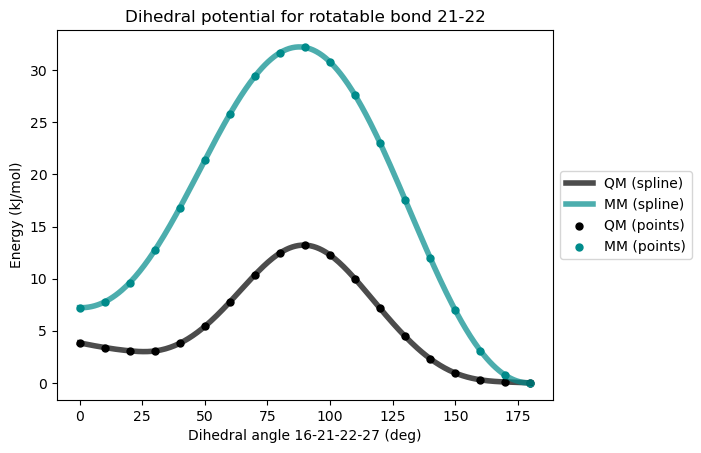

* Info * Fitting the dihedral parameters...                                                                               
* Info * Optimizing dihedral via least squares fitting...                                                                 
* Info * New fitted barriers: [1.85974413 1.85974413 1.85974413 1.85974413]                                               
* Info * Validating the fitted force field...                                                                             
                                                                                                                          
* Info * Summary of validation                                                                                            
* Info * ---------------------                                                                                            
* Info * Maximum difference: 5.311 kJ/mol                                                                                 
* Info * Standar

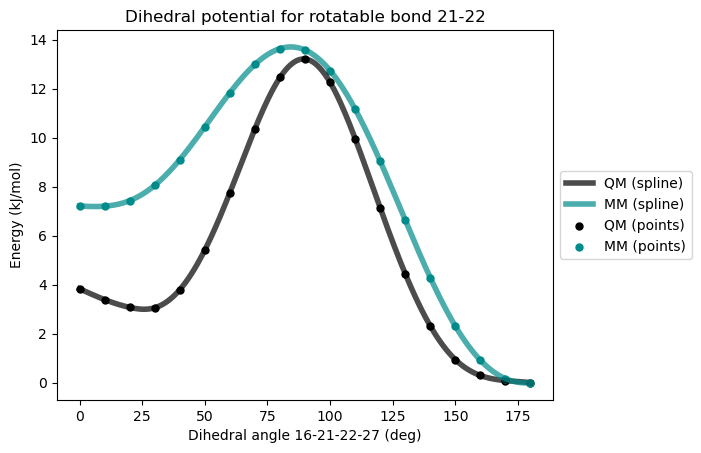

* Info * Dihedral MM parameters have been reparameterized and updated in the topology.                                    


In [3]:
reparam_summary = ff_gen.reparameterize_dihedrals(rotatable_bond=(21,22),
                                                  scan_file="../../data/md/27-22-21-16.xyz",
                                                  visualize=True,
                                                  verbose=False)

It is not uncommon that the existing dihedral terms in the force field are not sufficient to reproduce the QM potential. Here we can try adding more dihedral terms to the force field, and then redo the fitting. In this particular case we would like to lower the MM energy at 0$^{\circ}$ so that it matches the QM energy better. This corresponds to adding a dihedral term with periodicity 1 and phase 180$^{\circ}$. The barrier can be set to 0 since it will be fitted.

In [4]:
ff_gen.add_dihedral((16, 21, 22, 27), barrier=0.0, phase=180.0, periodicity=1)

* Info * Added dihedral 16-21-22-27                                                                                       


After adding the dihedral term we can redo the fitting. This time we can skip the initial validation step by setting `initial_validation` to `False`, since we already know how the MM potential energy curve looks. We can also set `show_diff` to `True` so that the difference between QM and MM energies will be plotted after the fitting.

                                          VeloxChem Dihedral Reparameterization                                           
                                                                                                                          
* Info * Rotatable bond selected: 21-22                                                                                   
* Info * Dihedrals involved:[[16, 21, 22, 23], [16, 21, 22, 27], [19, 21, 22, 23], [19, 21, 22, 27]]                      
* Info * Reading QM scan from file...                                                                                     
* Info *   ../../data/md/27-22-21-16.xyz                                                                                  
                                                                                                                          
* Info * Performing dihedral scan for MM baseline by excluding the involved dihedral barriers...                          
                

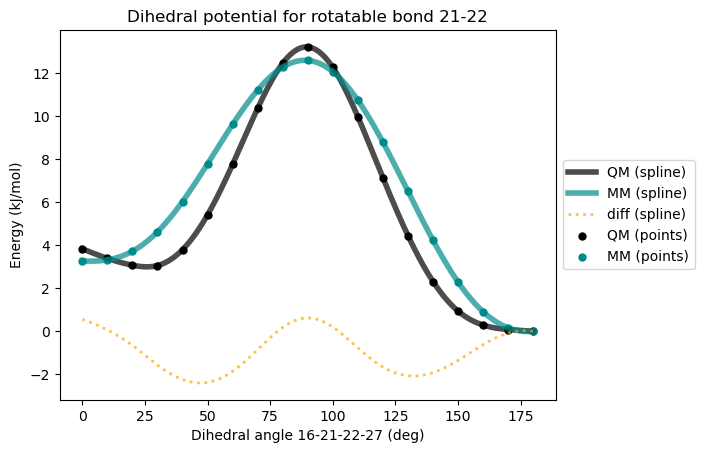

* Info * Dihedral MM parameters have been reparameterized and updated in the topology.                                    


In [5]:
reparam_summary = ff_gen.reparameterize_dihedrals(rotatable_bond=(21,22),
                                                  scan_file="../../data/md/27-22-21-16.xyz",
                                                  visualize=True,
                                                  verbose=False,
                                                  initial_validation=False,
                                                  show_diff=True)

Now we get better agreement between QM and MM energies. Since the difference between QM and MM is also plotted, we can tell that the MM energies can be brought closer to QM energies by adding one more dihedral term with periodicity 4 and phase 0$^{\circ}$.

In [6]:
ff_gen.add_dihedral((16, 21, 22, 27), barrier=0.0, phase=0.0, periodicity=4)

* Info * Added dihedral 16-21-22-27                                                                                       


                                          VeloxChem Dihedral Reparameterization                                           
                                                                                                                          
* Info * Rotatable bond selected: 21-22                                                                                   
* Info * Dihedrals involved:[[16, 21, 22, 23], [16, 21, 22, 27], [19, 21, 22, 23], [19, 21, 22, 27]]                      
* Info * Reading QM scan from file...                                                                                     
* Info *   ../../data/md/27-22-21-16.xyz                                                                                  
                                                                                                                          
* Info * Performing dihedral scan for MM baseline by excluding the involved dihedral barriers...                          
                

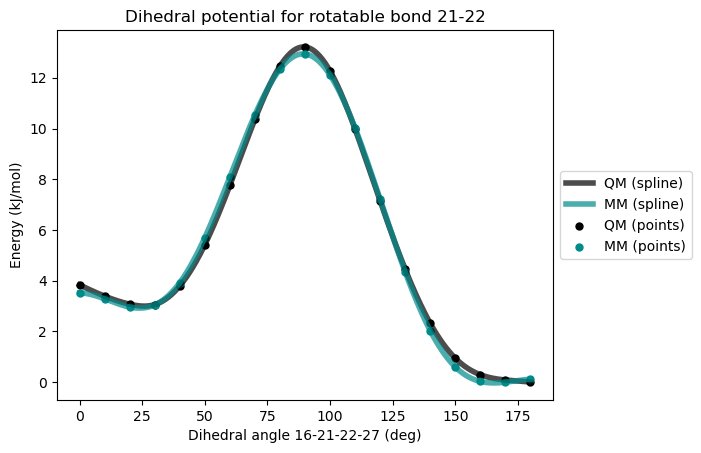

* Info * Dihedral MM parameters have been reparameterized and updated in the topology.                                    


In [7]:
reparam_summary = ff_gen.reparameterize_dihedrals(rotatable_bond=(21,22),
                                                  scan_file="../../data/md/27-22-21-16.xyz",
                                                  visualize=True,
                                                  verbose=False,
                                                  initial_validation=False)

## Save the force field to file

Use `write_gromacs_files` or `write_openmm_files` to write the force field to files.

In [8]:
ff_gen.write_gromacs_files('hs276')